# NQ Futures - Carga de Datos y Visualización

Este notebook carga los datos de NQ futures (2017-2025) y genera una visualización del precio.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import databento as db
from pathlib import Path
from typing import List, Optional
from pathlib import Path
Path('../output').mkdir(parents=True, exist_ok=True)

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

## 1. Configuración

In [27]:
# Ruta a los archivos de datos
DATA_DIR = Path("/Users/emiliosanchez/Desktop/pruebas_paco/test_TSI/data_markets copia/nasdaq")

# Años disponibles
YEARS = list(range(2017, 2026))  # 2017-2025

# Patrón de nombre de archivos
FILE_PATTERN = "NQ_futures_{year}_ohlcv-1m.dbn.zst"

## 2. Funciones de Carga y Limpieza

In [28]:
def load_dbn_file(filepath: Path) -> pd.DataFrame:
    """
    Carga un archivo DBN y devuelve DataFrame con OHLCV.
    """
    data = db.DBNStore.from_file(str(filepath))
    df = data.to_df()
    return df


def build_continuous_contract(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construye un contrato continuo usando el contrato más líquido por sesión.
    Excluye spreads (símbolos con '-').
    """
    # Filtrar solo contratos outright (sin spreads)
    df_futures = df[~df['symbol'].str.contains('-')].copy()
    
    # Determinar contrato dominante por día (mayor volumen)
    df_futures['date'] = df_futures.index.date
    daily_volume = df_futures.groupby(['date', 'symbol'])['volume'].sum().reset_index()
    dominant_contract = daily_volume.loc[daily_volume.groupby('date')['volume'].idxmax()]
    dominant_map = dominant_contract.set_index('date')['symbol'].to_dict()
    
    # Filtrar solo barras del contrato dominante
    df_futures['dominant'] = df_futures['date'].map(dominant_map)
    df_continuous = df_futures[df_futures['symbol'] == df_futures['dominant']].copy()
    
    return df_continuous[['open', 'high', 'low', 'close', 'volume']].sort_index()


def load_multiple_years(data_dir: Path, years: List[int], file_pattern: str) -> pd.DataFrame:
    """
    Carga múltiples años de datos y los concatena en un único DataFrame.
    """
    all_data = []
    
    for year in years:
        filepath = data_dir / file_pattern.format(year=year)
        
        if not filepath.exists():
            print(f"⚠️  Archivo no encontrado: {filepath.name}")
            continue
        
        print(f"📂 Cargando {filepath.name}...", end=" ")
        df_raw = load_dbn_file(filepath)
        df_continuous = build_continuous_contract(df_raw)
        print(f"{len(df_continuous):,} barras")
        
        all_data.append(df_continuous)
    
    if not all_data:
        raise ValueError("No se encontraron archivos de datos")
    
    # Concatenar todos los años
    df_full = pd.concat(all_data).sort_index()
    
    # Eliminar duplicados si los hay
    df_full = df_full[~df_full.index.duplicated(keep='first')]
    
    print(f"\n✅ Total: {len(df_full):,} barras de 1 minuto")
    print(f"   Desde: {df_full.index.min()}")
    print(f"   Hasta: {df_full.index.max()}")
    
    return df_full

## 3. Cargar Datos

In [29]:
# Cargar todos los años disponibles
df_1m = load_multiple_years(DATA_DIR, YEARS, FILE_PATTERN)

📂 Cargando NQ_futures_2017_ohlcv-1m.dbn.zst... 341,589 barras
📂 Cargando NQ_futures_2018_ohlcv-1m.dbn.zst... 347,872 barras
📂 Cargando NQ_futures_2019_ohlcv-1m.dbn.zst... 348,566 barras
📂 Cargando NQ_futures_2020_ohlcv-1m.dbn.zst... 347,608 barras
📂 Cargando NQ_futures_2021_ohlcv-1m.dbn.zst... 352,113 barras
📂 Cargando NQ_futures_2022_ohlcv-1m.dbn.zst... 354,113 barras
📂 Cargando NQ_futures_2023_ohlcv-1m.dbn.zst... 353,397 barras
📂 Cargando NQ_futures_2024_ohlcv-1m.dbn.zst... 353,694 barras
📂 Cargando NQ_futures_2025_ohlcv-1m.dbn.zst... 332,153 barras

✅ Total: 3,131,105 barras de 1 minuto
   Desde: 2017-01-02 23:00:00+00:00
   Hasta: 2025-12-09 23:59:00+00:00


In [30]:
# Vista previa de los datos
df_1m.head(10)

,open,high,low,close,volume
ts_event,,,,,
2017-01-02 23:00:00+00:00,4876.75,4890.25,4876.75,4888.00,488
2017-01-02 23:01:00+00:00,4888.00,4888.50,4887.00,4887.00,90
2017-01-02 23:02:00+00:00,4887.25,4888.00,4886.75,4887.75,70
2017-01-02 23:03:00+00:00,4887.75,4888.00,4887.50,4888.00,40
2017-01-02 23:04:00+00:00,4887.50,4890.00,4887.50,4890.00,89
2017-01-02 23:05:00+00:00,4889.75,4890.00,4887.50,4888.00,116
2017-01-02 23:06:00+00:00,4887.75,4889.25,4887.25,4888.00,128
2017-01-02 23:07:00+00:00,4887.50,4888.00,4887.00,4887.75,53
2017-01-02 23:08:00+00:00,4887.50,4887.75,4887.00,4887.75,62


In [31]:
# Estadísticas básicas
df_1m.describe()

,open,high,low,close,volume
count,3.131105e+06,3.131105e+06,3.131105e+06,3.131105e+06,3.131105e+06
mean,1.263766e+04,1.264017e+04,1.263511e+04,1.263766e+04,3.718220e+02
std,5.437737e+03,5.438626e+03,5.436812e+03,5.437737e+03,6.312429e+02
min,4.876750e+03,4.879000e+03,4.876750e+03,4.878500e+03,1.000000e+00
25%,7.498500e+03,7.500500e+03,7.496500e+03,7.498500e+03,4.200000e+01
50%,1.227300e+04,1.227650e+04,1.226925e+04,1.227300e+04,1.110000e+02
75%,1.587875e+04,1.588150e+04,1.587600e+04,1.587875e+04,4.280000e+02
max,2.639575e+04,2.639900e+04,2.639400e+04,2.639625e+04,2.036800e+04


## 4. Visualización del Precio

In [32]:
def resample_ohlcv(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Resamplea datos OHLCV a un timeframe mayor.
    
    Args:
        df: DataFrame con columnas OHLCV e índice datetime
        timeframe: String de pandas (ej: '5min', '1H', '1D')
    """
    return df.resample(timeframe).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()

In [33]:
# Resamplear a diario para visualización del histórico completo
df_daily = resample_ohlcv(df_1m, '1D')
print(f"Datos diarios: {len(df_daily)} sesiones")

Datos diarios: 2777 sesiones


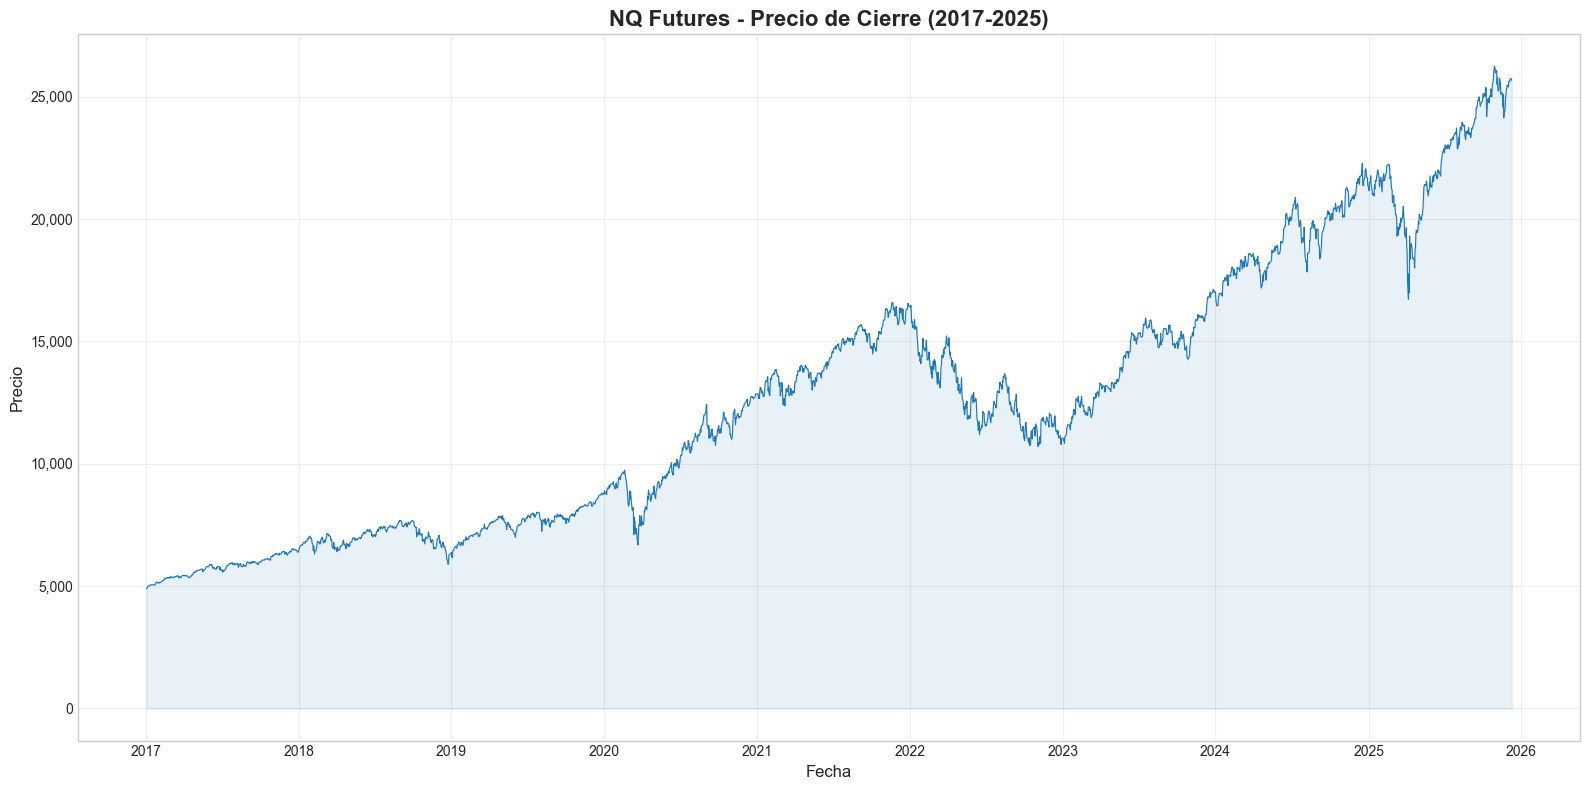

In [34]:
# Gráfico del precio histórico
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df_daily.index, df_daily['close'], color='#1f77b4', linewidth=0.8)
ax.fill_between(df_daily.index, df_daily['close'], alpha=0.1, color='#1f77b4')

ax.set_title('NQ Futures - Precio de Cierre (2017-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Precio', fontsize=12)
ax.grid(True, alpha=0.3)

# Formato del eje Y con separador de miles
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.savefig('../output/nq_price_history.png', dpi=150, bbox_inches='tight')
plt.show()

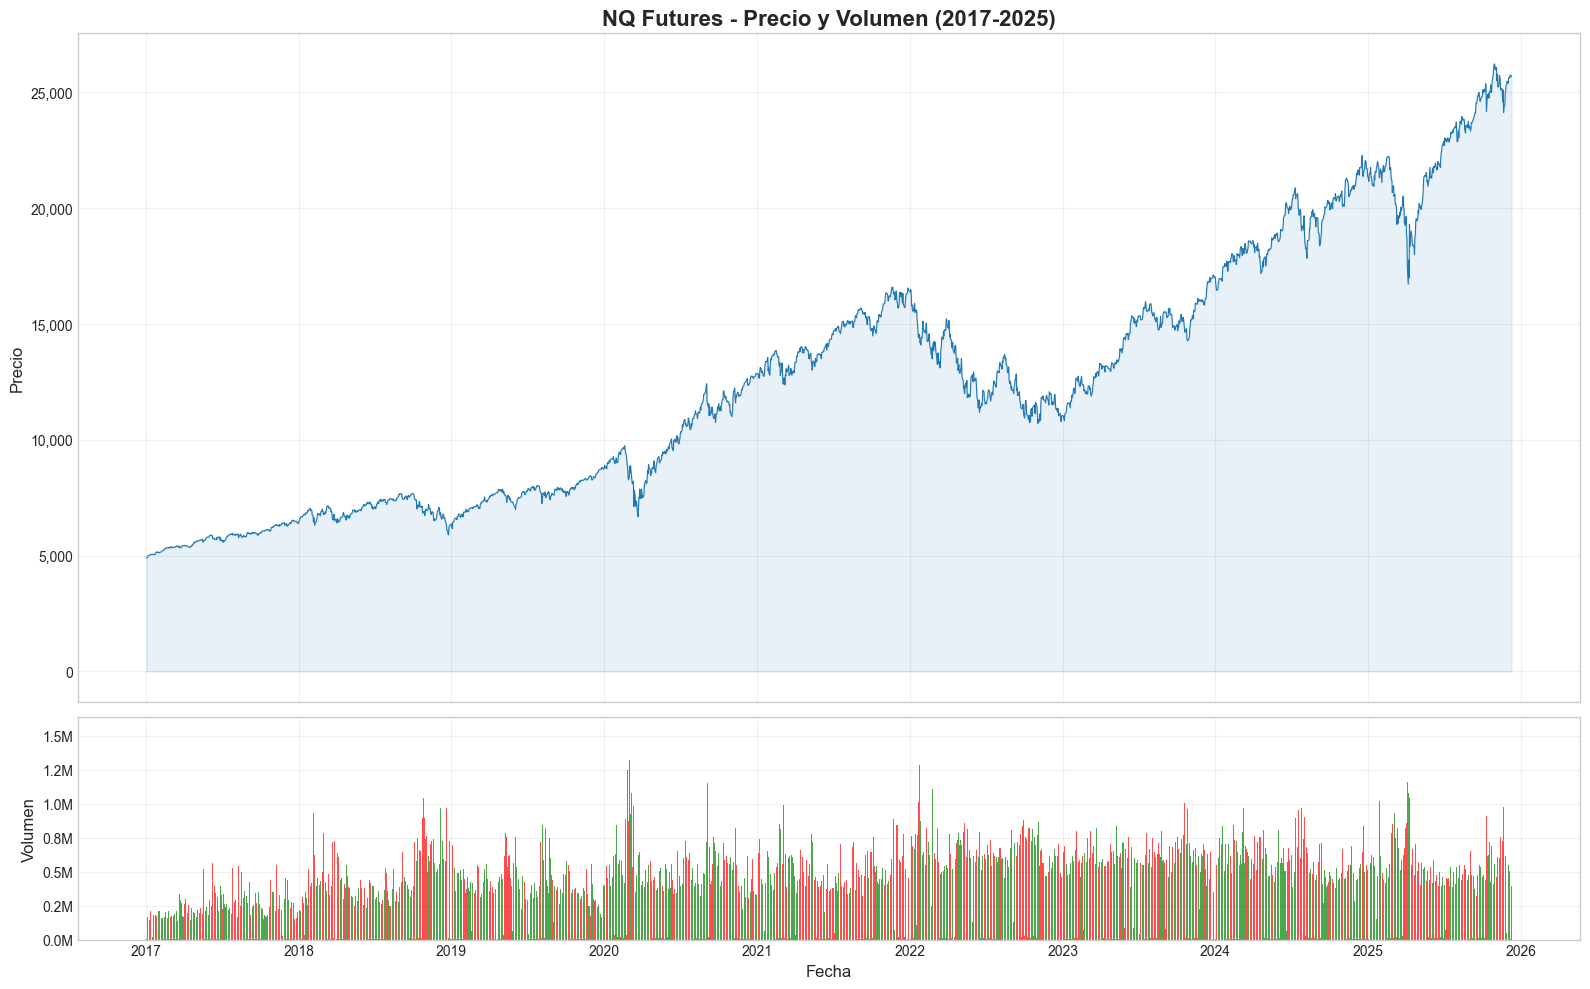

In [35]:
# Gráfico con volumen
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), height_ratios=[3, 1], sharex=True)

# Precio
ax1.plot(df_daily.index, df_daily['close'], color='#1f77b4', linewidth=0.8)
ax1.fill_between(df_daily.index, df_daily['close'], alpha=0.1, color='#1f77b4')
ax1.set_ylabel('Precio', fontsize=12)
ax1.set_title('NQ Futures - Precio y Volumen (2017-2025)', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Volumen
colors = ['green' if df_daily['close'].iloc[i] >= df_daily['open'].iloc[i] else 'red' 
          for i in range(len(df_daily))]
ax2.bar(df_daily.index, df_daily['volume'], color=colors, alpha=0.7, width=1)
ax2.set_ylabel('Volumen', fontsize=12)
ax2.set_xlabel('Fecha', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.savefig('../output/nq_price_volume_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Estadísticas por Año

In [36]:
# Estadísticas anuales
df_daily['year'] = df_daily.index.year
df_daily['return'] = df_daily['close'].pct_change()

yearly_stats = df_daily.groupby('year').agg({
    'open': 'first',
    'close': 'last',
    'high': 'max',
    'low': 'min',
    'volume': 'sum',
    'return': lambda x: (1 + x).prod() - 1  # Retorno anual compuesto
}).round(2)

yearly_stats.columns = ['Apertura', 'Cierre', 'Máximo', 'Mínimo', 'Volumen Total', 'Retorno %']
yearly_stats['Retorno %'] = (yearly_stats['Retorno %'] * 100).round(2)

yearly_stats

,Apertura,Cierre,Máximo,Mínimo,Volumen Total,Retorno %
year,,,,,,
2017,4876.75,6385.00,6545.75,4876.75,64251959,31.0
2018,6405.00,6342.75,7728.75,5820.50,117269892,-1.0
2019,6349.50,8735.00,8843.50,6136.50,108813209,38.0
2020,8776.75,12849.75,12918.25,6628.75,137020932,47.0
2021,12889.00,16437.75,16767.50,12207.25,131837413,28.0
2022,16356.00,11041.75,16564.00,10484.75,166421172,-33.0
2023,11122.50,17003.75,17165.25,10751.00,157171637,54.0
2024,17019.00,21391.25,22425.75,16334.25,148419176,26.0
2025,21269.00,25671.50,26399.00,16460.00,133008277,20.0


## REPRESENTACIÓN HEIKEN-ASHI

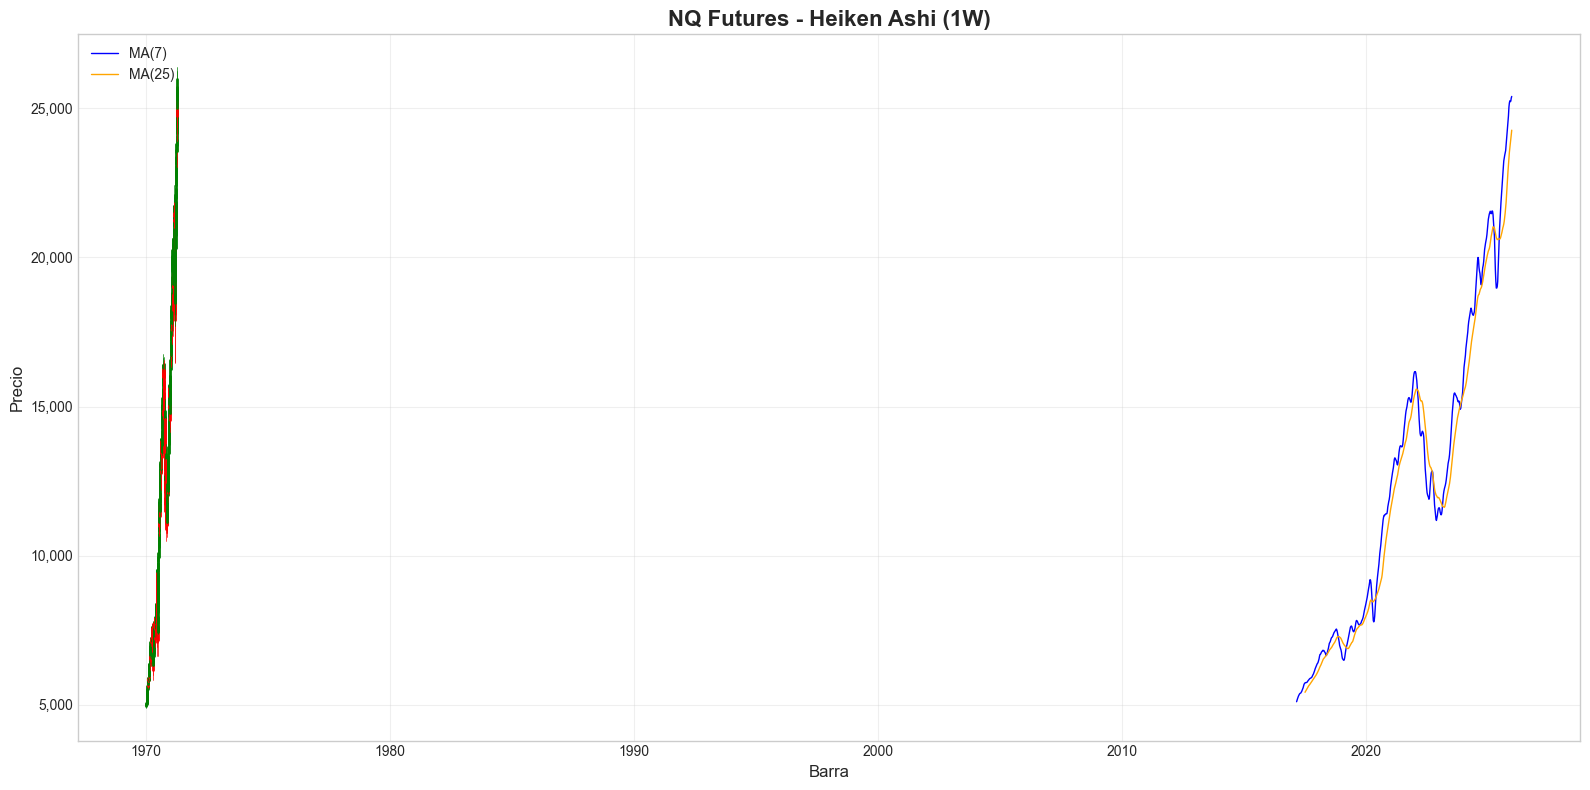

Timeframe: 1W
Total barras: 467
Desde: 2017-01-08 00:00:00+00:00
Hasta: 2025-12-14 00:00:00+00:00


In [42]:
# =============================================================================
# HEIKEN ASHI - Timeframe configurable
# =============================================================================
# Opciones de timeframe: '1min', '2min', '5min', '15min', '30min', '1H', '4H', '1D', '1W'

TIMEFRAME = '1W'  # <-- Cambia aquí el timeframe que quieras

# Resamplear al timeframe elegido
df_tf = resample_ohlcv(df_1m, TIMEFRAME)

# Parámetros medias móviles
SHOW_MA = True  # True para mostrar, False para ocultar
MA_1_PERIOD = 7
MA_2_PERIOD = 25

# Calcular velas Heiken Ashi
def calculate_heiken_ashi(df):
    """Calcula Heiken Ashi - versión vectorizada"""
    ha = pd.DataFrame(index=df.index)
    
    # HA Close = promedio de OHLC
    ha['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    
    # HA Open = promedio recursivo del HA_Open y HA_Close anteriores
    # Inicializar con el promedio del primer O y C
    ha_open = np.zeros(len(df))
    ha_open[0] = (df['open'].iloc[0] + df['close'].iloc[0]) / 2
    
    # Calcular recursivamente
    for i in range(1, len(df)):
        ha_open[i] = (ha_open[i-1] + ha['close'].iloc[i-1]) / 2
    
    ha['open'] = ha_open
    
    # HA High y Low
    ha['high'] = df[['high']].join(ha[['open', 'close']]).max(axis=1)
    ha['low'] = df[['low']].join(ha[['open', 'close']]).min(axis=1)
    
    return ha[['open', 'high', 'low', 'close']]

df_ha = calculate_heiken_ashi(df_tf)


if SHOW_MA:
    df_ha['MA_1'] = df_ha['close'].rolling(MA_1_PERIOD).mean()
    df_ha['MA_2'] = df_ha['close'].rolling(MA_2_PERIOD).mean()

# Dibujar gráfico de velas Heiken Ashi
fig, ax = plt.subplots(figsize=(16, 8))

# Colores según dirección
colors = ['green' if df_ha['close'].iloc[i] >= df_ha['open'].iloc[i] else 'red' 
          for i in range(len(df_ha))]

# Dibujar velas
for i, (idx, row) in enumerate(df_ha.iterrows()):
    color = colors[i]
    # Cuerpo de la vela
    ax.plot([i, i], [row['low'], row['high']], color=color, linewidth=0.5)
    ax.plot([i, i], [row['open'], row['close']], color=color, linewidth=2)
if SHOW_MA:
    ax.plot(df_ha.index, df_ha['MA_1'], color='blue', linewidth=1, label=f'MA({MA_1_PERIOD})')
    ax.plot(df_ha.index, df_ha['MA_2'], color='orange', linewidth=1, label=f'MA({MA_2_PERIOD})')
    ax.legend(loc='upper left')    

ax.set_title(f'NQ Futures - Heiken Ashi ({TIMEFRAME})', fontsize=16, fontweight='bold')
ax.set_ylabel('Precio', fontsize=12)
ax.set_xlabel('Barra', fontsize=12)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

print(f"Timeframe: {TIMEFRAME}")
print(f"Total barras: {len(df_ha):,}")
print(f"Desde: {df_ha.index.min()}")
print(f"Hasta: {df_ha.index.max()}")